# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [73]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [74]:
if os.path.exists('/content/data'):
  shutil.rmtree('/content/data')

os.mkdir('/content/data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O /content/data/data.zip
!unzip "/content/data/data.zip" -d "/content/"
os.system("rm /content/data/data.zip")
data_dir = '/content/data/'


--2024-12-02 05:16:47--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 173.194.210.139, 173.194.210.138, 173.194.210.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.210.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2024-12-02 05:16:47--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘/content/data/data.zip’

/content/data/data. 100%[===================>]   5.92M  -

Utils Functions.

In [75]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

In the n-dot-l model, \\
1. $\vec{n}$ is a unit vector representing the surface normal.
1. $\vec{l}$ is a unit vector representing the light direction, i.e., pointing from the surface to the light source. \\
Since both $\vec{n}$ and $\vec{l}$ are unit vectors, the dot product $\vec{n} \cdot \vec{l} = cos(\theta)$, $\theta$ is the angle between $\vec{n}$ and $\vec{l}$. This signifies how directly the light hits the surface. It is used to compute the intensity of radiance or irradiance from the surface. \\

The $\vec{n} \cdot \vec{l}$ term is directly proportional to the projected area of the surface, seen by the light source. As the angle between $\vec{n}$ and $\vec{l}$ increases, the effective area receiving light decreases. This relationship is captured by the $cos(\theta)$ term, represented by $\vec{n} \cdot \vec{l}$.

In a Lambertian Model, the viewing direction does not matter because:
1. The surface will scatter light equally in all directions.
1. The amount of light reflected only depends on the angle of incidence from the light source.

Hence, the $\vec{n} \cdot \vec{l}$ model does not include a term to account for the viewing direction.

---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

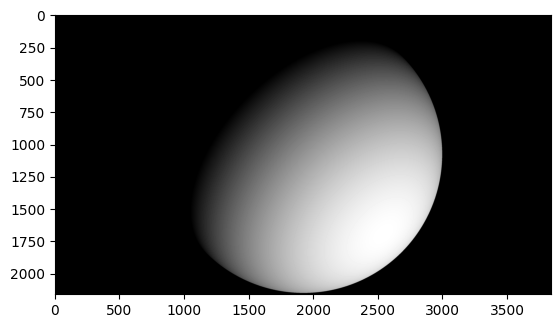

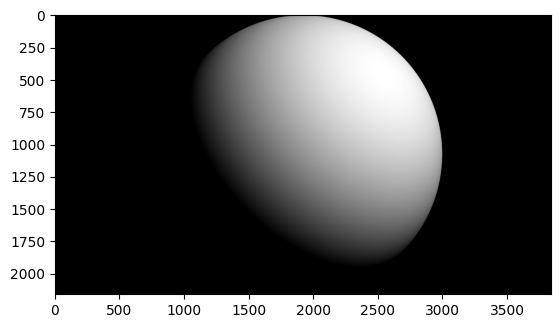

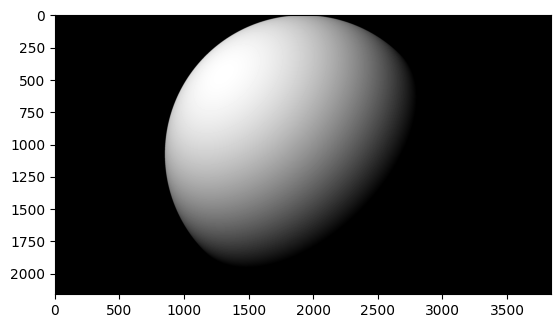

In [76]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = np.zeros([res[1],res[0]])

    ### YOUR CODE HERE
    l = light
    l = l / np.linalg.norm(l)

    n = np.array([X - center[0], Y - center[1], Z - center[2]])
    n = n / np.linalg.norm(n)

    image = np.dot(n.T, l)
    image = image / np.linalg.norm(image)
    image = np.clip(image, 0, 1)
    image = image.T
    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [77]:
### YOUR CODE HERE
S= np.linalg.svd(I, compute_uv=False)
print(S)
### END YOUR CODE

[79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---

The rank of I should be 3 because $ I = L^T \cdot B$. \\
We know that the rank of a matrix product is at most the minimum of the ranks of the factors i.e., $$ rank(I) \le min(rank(L^T), rank(B))$$
where,
$$ L^T \in \mathbb{R}^{7 \times 3} \\
B \in \mathbb{R}^{3 \times P} \\
\implies rank(I) \le 3$$

This rank of 3 represents the nature of the problem: trying to recover 3D normals from 2D images. The rank indicates that the intensity variations in this image encode the 3D transformation.

As seen in the code above, the SVD of $I$ gived $7$ singular values. However, apart from the first $3$, the singular values have low enough magnitudes to be attributed to measurement noise as well as any mathematical approximations made during the conversion process. While theoretically the $I$ matrix should have rank $3$, practical examples with real image data always contain randomness and disturbances.

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [78]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
    y = I.flatten()
    A = spkron(L.T, speye(I.shape[1]))
    B = np.array([splsqr(A,y)[0]])
    B = B.reshape(3,-1)

    print(min(B.flatten()),max(B.flatten()))
    # B = np.linalg.pinv(L.T) @ I
    ### END YOUR CODE
    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


-0.8772164874686781 0.8090796488092981


---

To create the linear system $Ax = y$ based on the equation $ L^T\cdot B = I$, \\
- Since we are solving for $B$, the $y$ matrix will be created using $I$, the $A$ matrix will be constructed using $L^T$ and the $x$ matrix will be the created using the variable $B$.
- The vector $y$ is created by flattening the $I$ matrix to a vector of length $7P$.
- The $A$ matrix is created as a block diagonal matrix, with each block being $L^{-T}$. The Kronecker product is used to construct the matrix of size $7P\times3P$.
- The $B$ matrix is computed using the $scipy.sparse.linalg.lsqr$ solver and reshaped to the desired size of $3\times P$.

---


### Q 1 (e) Albedos and normals (10 points)

---

An unnatural feature is the inconsistent lighting around curvatures such as the nose and the ear. This could be due to certain lighting directions causing high irradiance and some causing low irradiance, leading to skewing of the estimates.

Additionally, some features like the chin are slightly morphed owing to high variance in viewed shape with change in the lighting direction.

---

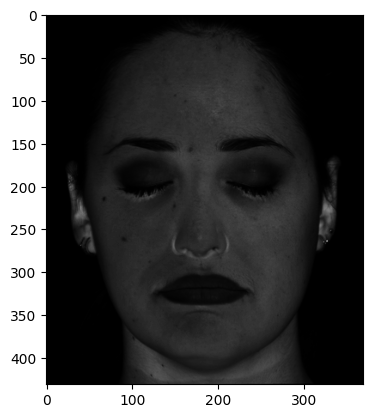

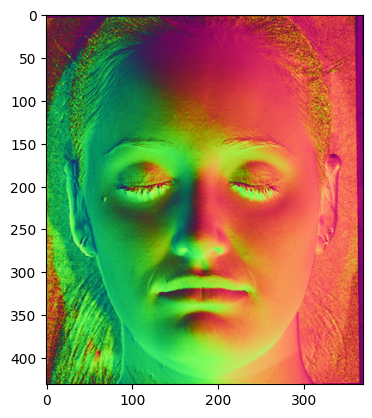

In [79]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE

    albedos = np.linalg.norm(B,axis=0)
    albedos /= max(albedos.flatten())
    # print(min(albedos.flatten()),max(albedos.flatten()))

    normals = B / albedos.reshape(1,-1)
    normals /= np.linalg.norm(normals,axis=0)
    # print(min(normals.flatten()),max(normals.flatten()))

    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

A 3D Depth Map is a surface represented by $ z = f(x,y) $. At any given point $(x,y)$, we can define two tangent vectors $\vec{v_1}$ and $\vec{v_2}$.
$$
f_x = \frac{\partial f(x,y)}{\partial x} \space \space  f_y = \frac{\partial f(x,y)}{\partial y} \\
\vec{v_1} = \begin{pmatrix} 1 & 0 & f_x \end{pmatrix} \\
\vec{v_2} = \begin{pmatrix} 0 & 1 & f_y \end{pmatrix}
$$
The normal vector is perpendicular to the tangent plane represented by $\vec{v_1}$ and $\vec{v_2}$. Hence we can use the cross product to find $\vec{n}$.
$$
\vec{n} = \vec{v_1} \times \vec{v_2} = \begin{pmatrix} -f_x & -f_y & 1 \end{pmatrix} = \begin{pmatrix} n_1 & n_2 & n_3 \end{pmatrix}
$$
To get the unit normal, we divide $\vec{n}$ by its magnitude, \\
$$
n_1 = \frac{-f_x}{\sqrt{f_x^2+f_y^2+1^2}} \space \space
n_2 = \frac{-f_y}{\sqrt{f_x^2+f_y^2+1^2}} \space \space
n_3 = \frac{1}{\sqrt{f_x^2+f_y^2+1^2}} \\
$$
This gives us the final unit normal vector $\vec{n}$,
$$
\vec{n} = \begin{pmatrix} \frac{-f_x}{\sqrt{f_x^2+f_y^2+1^2}} & \frac{-f_y}{\sqrt{f_x^2+f_y^2+1^2}} & \frac{1}{\sqrt{f_x^2+f_y^2+1^2}} \end{pmatrix}
$$
Hence,
$$
f_x = \frac{\partial f(x,y)}{\partial x} = -\frac{n_1}{n_3}\\
f_y = \frac{\partial f(x,y)}{\partial y} = -\frac{n_2}{n_3}
$$


---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

The x gradient $g_x$ is calculated using $g_x(x_i, y_j) = g(x_{i+1},y_j) - g(x_i, y_j)$.
$$
g_x = \begin{pmatrix} 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \\ 0 & 0 & 0 & 0 \end{pmatrix}
$$
The y gradient $g_x$ is calculated using $g_y(x_i, y_j) = g(x_i,y_{j+1}) - g(x_i, y_j)$.
$$
g_y = \begin{pmatrix} 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 0 \end{pmatrix}
$$
Reconstruction is done in two ways:
1. Use $g_x$ to construct the first row of $g$, then use $g_y$ to construct the rest of $g$
$$
g = \begin{pmatrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16 \end{pmatrix}
$$

2. Use $g_y$ to construct the first column of $g$, then use $g_x$ to construct the rest of $g$.
$$
g = \begin{pmatrix} 1 & 5 & 9 & 13 \\ 2 & 6 & 10 & 14 \\ 3 & 7 & 11 & 15 \\ 4 & 4 & 4 & 4 \end{pmatrix}
$$

The discrepancy arises from inconsistencies between $g_x$ and $g_y$. For example, when reconstructing the last row using Method 2, we use $g_x(0, 3) = 0$, which doesn't align with the values in the original matrix.

To make $g_x$ and $g_y$ integrable, they must satisfy the following condition.
$$
\frac{\partial^2f}{\partial x \cdot \partial y} = \frac{\partial^2f}{\partial y \cdot \partial x}
$$
This implies that:
1. The change in x-direction $g_x$ is consistent across all rows.
1. The change in y-direction $g_y$ is consistent across all columns.

An example of the modified gradients that are integrable are:
$$
g_x = \begin{pmatrix} 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \end{pmatrix} \space \space \space g_y = \begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \end{pmatrix}
$$

---

### Q 1 (h): Shape estimation (10 points)

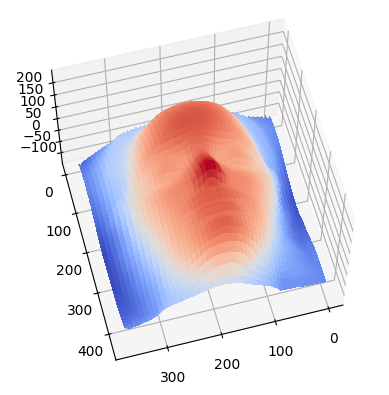

In [80]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE
    zx = (- normals[0] / normals[2]).reshape(s)
    zy = (- normals[1] / normals[2]).reshape(s)
    surface = integrateFrankot(zx, zy)


    ### END YOUR CODE
    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

To construct the factorization,
1. Perform SVD on matrix $I$, giving $I = U \Sigma V^T$.
1. To modify the singular values, we set all but the top 3 singular values to 0, resulting in a new diagonal matrix $\hat{\Sigma}$.
1. Reconstruct the matrix using the modified singular values to get $\hat{I}$, which is the best rank-3 approximation.
1. We can estimate $L^T$ and $B$ using the new $\hat{I}$,
$$
L^T = U_k(\hat{\Sigma}_k^{1/2})^T, \space B = (\hat{\Sigma}_k^{1/2}) V_k^T
$$
where, $L^T$ uses the first 3 columns and $B$ uses the first 3 rows of the given expressions.

---

### Q 2 (b): Calculation and visualization (10 points)

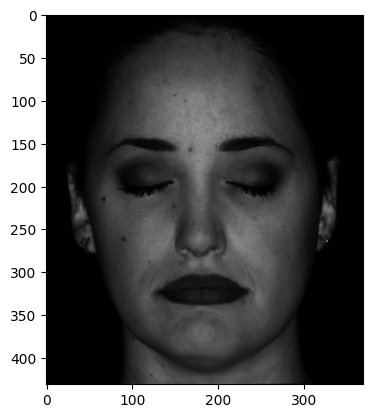

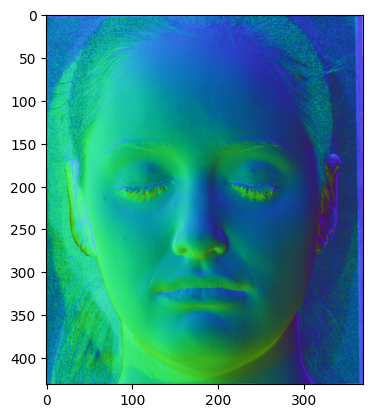

In [81]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	U,S,Vh = np.linalg.svd(I, full_matrices = False)
	S_rank3 = np.zeros_like(S)
	S_rank3[:3] = S[:3]
	S_rank3 = np.diag(S_rank3)
	I_hat = U @ S_rank3 @ Vh
	L = (U[:,:3] @ np.sqrt(S_rank3[:3,:3]).T)
	L = L.T
	B = np.sqrt(S_rank3[:3,:3]) @ Vh[:3,:]
	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


### Q 2 (c): Comparing to ground truth lighting

---

It is evident that $L \in (-1,1)$ and $\hat{L}$ has an arbitrary range. Adding a transformation matrix while computing $\hat{L}$ and $B$ could help scale them to the range of ground truth $L$ and $B$. \\
$$
New \space \hat{L}^T = U_k \space @ \space (\hat{\Sigma}_k^{1/2})^T \space @ \space R^T \\
New \space B = R \space @ \space  (\hat{\Sigma}_k^{1/2}) \space @ \space V_k^T
$$


---


In [82]:
print('L = ', L)
print('L_hat = ', LEst)

L =  [[-0.1418  0.1215 -0.069   0.067  -0.1627  0.      0.1478]
 [-0.1804 -0.2026 -0.0345 -0.0402  0.122   0.1194  0.1209]
 [-0.9267 -0.9717 -0.838  -0.9772 -0.979  -0.9648 -0.9713]]
L_hat =  [[-2.99267472 -3.86998525 -2.40803005 -3.74500806 -3.59135539 -3.38666635
  -3.3525448 ]
 [ 0.94780484 -2.31708946  0.49911094 -0.62599426  2.32568155  0.46605103
  -0.79271078]
 [ 1.87934697  1.01461663  0.42942606 -0.01730299 -0.3107729  -0.91273581
  -1.8830081 ]]


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

This does not look like a face. By looking at the map, the z-axis has a very high range, indicating randomness. This is probably influenced by the arbitrary range of $\hat{L}$. Additionally, the integrability constraint is not satisfied leading to unequal gradients in different directions.

---

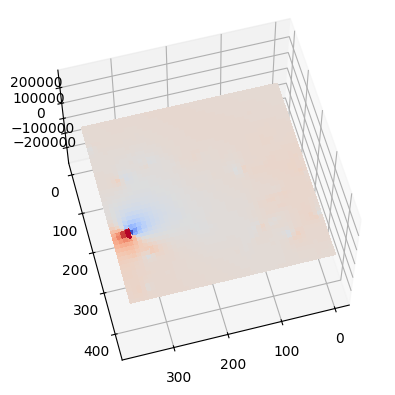

In [83]:
# Part 2 (d)
### YOUR CODE HERE
surface = estimateShape(normals, s)
plotSurface(surface)
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

This surface does look like the output produced by the calibrated photometric stereo.

---


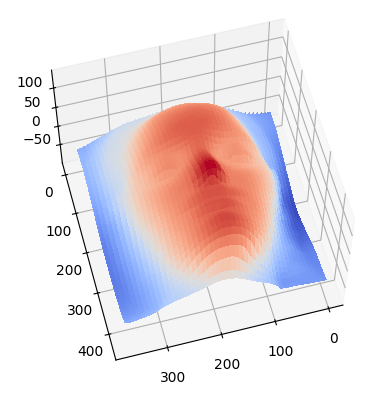

In [84]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE
Bt = enforceIntegrability(B, s)
albedos, new_normals = estimateAlbedosNormals(Bt)
surface_2 = estimateShape(new_normals,s)
plotSurface(surface_2)
### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

The ambiguity is named low-relief because the sculptures are only slightly raised from the surface, creating a subtle 3D effect. The sculptures are etched directly onto a flat surface. Hence, the minimal projection from the flat surface is the key reason for the ambiguity to be called 'bas-relief'.

The parameters affect the surface by:
1. $\lambda$: Scales the depth of the surface. Depth is shallow when 0 < $\lambda$ < 1.
1. $\nu$: Introduces a tilt in the y-direction. This can affect how light interacts with the surface.
1. $\mu$: Introduces a tilt in the x-direction. This can alter the perceived orientation of features.

---

<IPython.core.display.Javascript object>

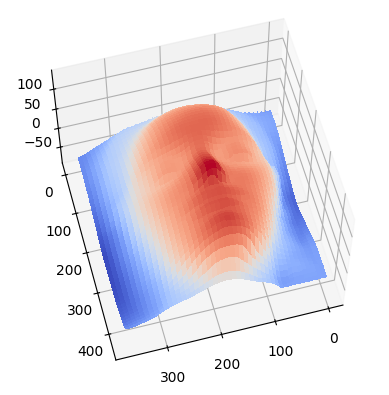

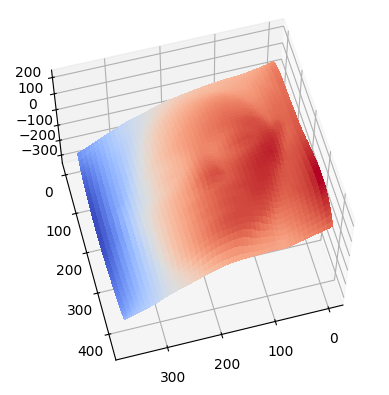

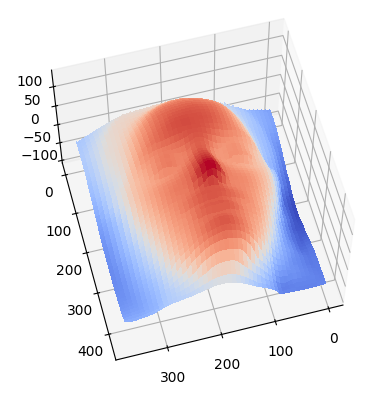

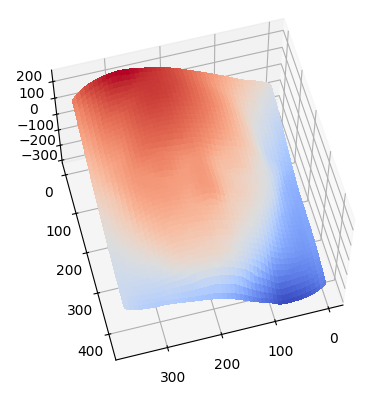

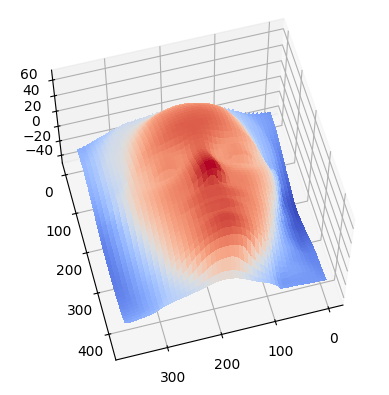

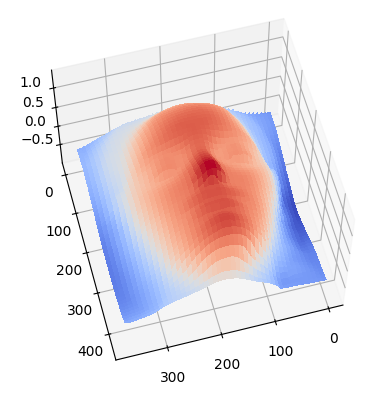

In [85]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE
B = enforceIntegrability(B, s)
mus = [0.5, 6]
nus = [0.5, 6]
lambdas = [0.5, 0.01]
for mu in mus:
  plotBasRelief(B, mu, 0, 1)
for nu in nus:
  plotBasRelief(B, 0, nu, 1)
for lam in lambdas:
	plotBasRelief(B, 0, 0, lam)
### END YOUR CODE

### Q 2 (g): Flattest surface possible (5 points)

---

To design a transformation that makes the estimated surface as flat as possible:
- Choose a very small positive value for $\lambda$ to minimise the depth deviations in the surface
- Choose the values of $\nu$ and $\mu$ to counteract remaining slopes and tilts in the surface \\

This transformation will compress the depth range of the surface while preserving the relative depth ordering of points, resulting in an extremely flat bas-relief surface.

---

### Q 2 (h): More measurements

---

Acquiring more pictures from additional lighting directions will not fully resolve the bas-relief ambiguity:
- The ambiguity is fundamental to shape-from-shading problems, persisting even with multiple images.
- The Generalized Bas-Relief (GBR) transformation allows different surfaces to produce identical images under transformed lighting.
- Photometric stereo techniques, even with many images, cannot completely eliminate this ambiguity.

While more images may improve surface normal estimates, they cannot break the inherent ambiguity in determining the exact surface shape.


---